cpu


C:\Users\HansW\mitwworkspace\MakeAIWork2\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HansW\mitwworkspace\MakeAIWork2\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

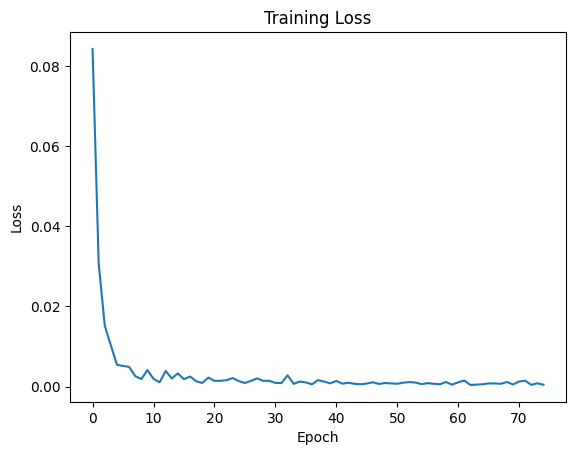

In [4]:
import os
import cv2
import torch
import os.path
import torchvision
import pandas as pd
import torch.nn as nn
import torch.cuda as cuda
import torchvision.io as io
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
from torchvision.datasets import ImageFolder
from torchvision.io import ImageReadMode 
from torchsummary import summary
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

image_size = 64
batch_size = 16
num_classes = 4
num_epochs = 75

def label_images_in_directories(main_directory):
    label_names = []
    image_files = []
    for directory in os.listdir(main_directory):
        sub_directory = os.path.join(main_directory, directory)
        if os.path.isdir(sub_directory):
            for filename in os.listdir(sub_directory):
                image_file = os.path.join(sub_directory, filename)
                if os.path.isfile(image_file) and filename.endswith(".jpg"):
                    label_names.append(directory)
                    image_files.append(image_file)

    image_tensors = [torchvision.io.read_image(image, mode=ImageReadMode.UNCHANGED).to(torch.float32)/255 for image in image_files]
    nr_of_images = len(image_tensors)

    return label_names, image_tensors

train_dir = "./../../Project 3/data/Data_cleaning_step1_2/Train"
label_names, image_tensors = label_images_in_directories(train_dir)

test_dir = "./../../Project 3/data/Data_cleaning_step1_2/Test"
label_names, image_tensors = label_images_in_directories(test_dir)

# Define the transformations before entering the neural network
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

# Load the training and test datasets
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Create DataLoaders for managing the data batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Resnet model
resnet = models.resnet18(pretrained=True)

# Change the number of output features in the last fully connected layer
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)
summary(resnet.to(device), input_size=(3,image_size,image_size))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# 6. Train the model
totalLoss = []

for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0.0
    train_correct = 0
    losses = []

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        
    train_loss = train_loss / len(train_dataset)
    train_acc = (train_correct / len(train_dataset))*100
    totalLoss.append(sum(losses)/len(train_dataset))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

# 7. Evaluate the model
resnet.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_acc = 100 * total_correct / total_samples
print(f"Accuracy: {test_acc:.2f}%")

# Save model
torch.save(resnet.state_dict(), "model_apple_resnet.pth")

data = {
    "Image Resize": str(image_size)+"*"+str(image_size),
    "Epochs": num_epochs,
    "Train Accuracy": train_acc,
    "Test Accuracy": test_acc,
    "Dataset use": os.path.basename(train_dir),
    "Model type": "resnet18"
}

# Check if the CSV file already exists
if os.path.isfile("model_data.csv"):
    existing_data = pd.read_csv("model_data.csv")
    new_data = pd.concat([existing_data, pd.DataFrame(data, index=[0])], ignore_index=True)

else:
    new_data = pd.DataFrame(data, index=[0])

# Save the updated DataFrame to CSV
new_data.to_csv("model_data.csv", index=False)


fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Loss', title="Training Loss")

plt.plot(totalLoss)
plt.show()
